In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np

import scanpy as sc
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [2]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'detectability' : 'max'}).reset_index()
    return data


def summarise_per_class(df, groupby_columns):
    
    data = df.groupby(groupby_columns).agg({'detectability' : 'sum',
                                            'class_size': 'first'
                                            }).reset_index()

    data['fraction_detected'] = data.detectability / data['class_size'] 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    return data


def assemble_adata(pca):
    observables = pca.index.to_frame(index=False)
    for col in observables.columns:
        observables[col] = observables[col].astype('category')  
    variables = pca.columns.to_frame(index=False)
    adata = AnnData(pca.values, obs=observables, var=variables)
    return adata

- Inputs

In [3]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "20_matrices/5_data_analysis"
p_out = p_root_dir / "interlab/pca_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_root_dir / r"interlab\interlab_data_from_Mans\2022-06-17_All_Interlab_Predictions.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

- Merge relevant info into one dataframe

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val']]

predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
metadata_columns = ['Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                    'Slide code',
#                     'EMBL',
                    'Interlab', 
                    'All', 
#                     'Shared matrix (temporary)'
                   ]
datasets_info = datasets.groupby('Dataset ID').first()[metadata_columns]

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only interlab datasets + EMBL datasets with 10ppm
df = df[df['Interlab']] 

# only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

## Option 1: Build PCA based on the intenisities and detectability of all metabolites
- Each metabolite is an average of its detected ions

In [9]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
#                             polarity='negative', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Reshape
pca = molecule_data.pivot_table(values='detectability', 
                                 index=metadata_columns, 
                                 columns='name_short',
                                 fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# # Apply Z-score normalisation
# sc.pp.scale(adata, zero_center=True) # I think if we use detectability only this is not needed

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<ipython-input-10-19aff90abef1>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


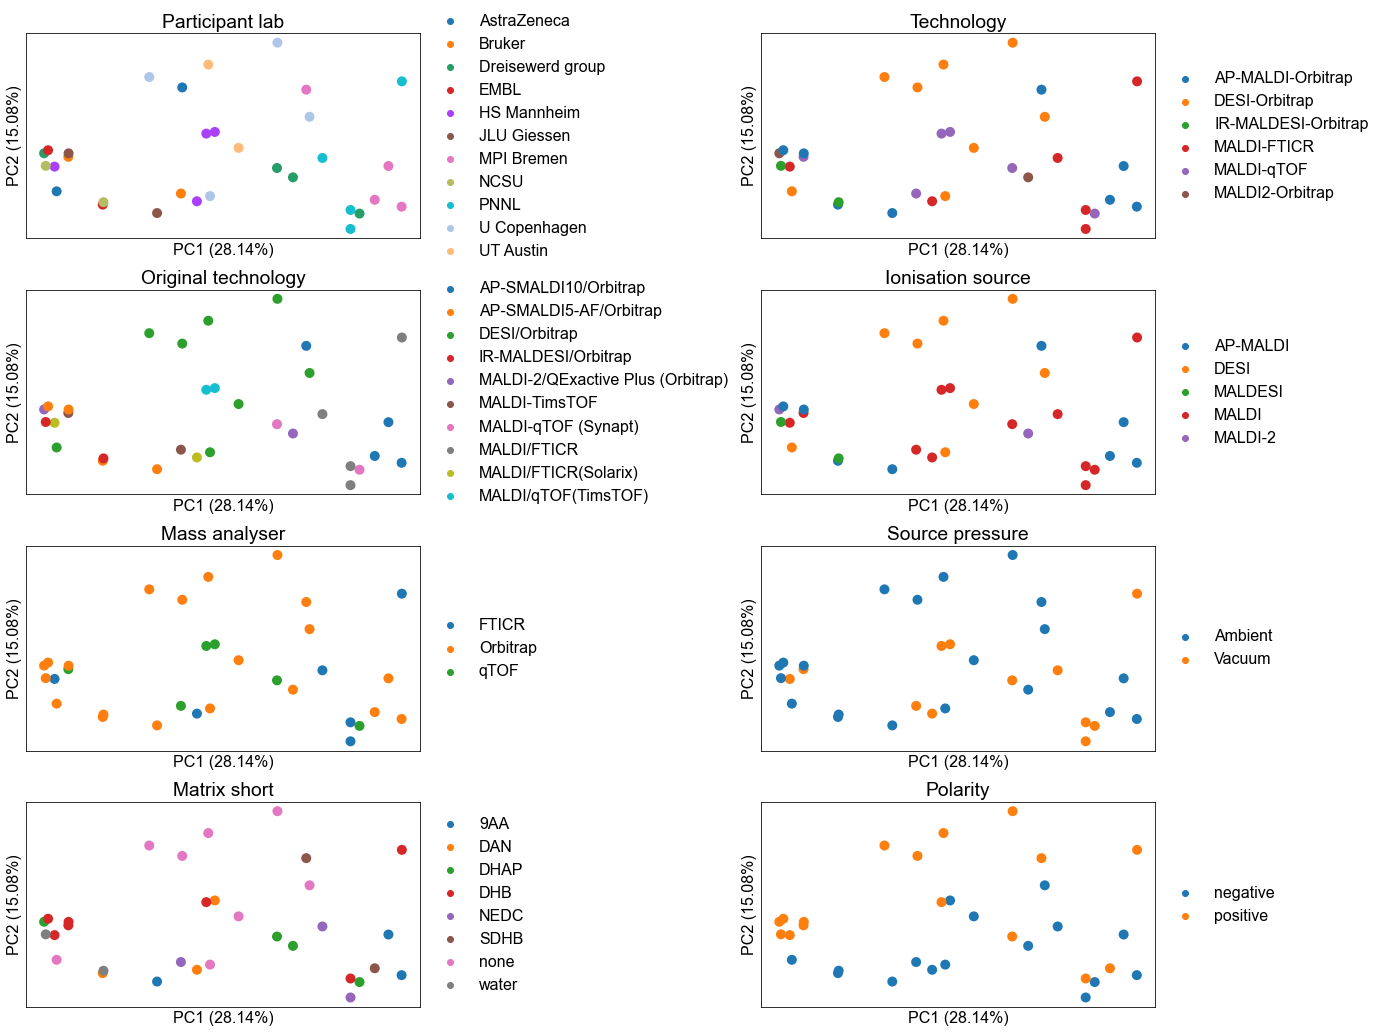

In [10]:
fname = "PCA_interlab_both"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
                    'Polarity', 
                   ],
                   size=400, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.7,
                   annotate_var_explained = True)
    plt.tight_layout()
    plt.savefig(p_out/ f"{fname}.png")
    plt.savefig(p_out / f"{fname}.pdf")

## Option 2: PCA based on the aggregated values also used in coarse class dot plot
- This is useful in case you want to see PCA loadings

In [11]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

In [17]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='negative', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=np.append(metadata_columns, 'main_coarse_class').tolist())

# Reshape
pca = class_data.pivot_table(values='fraction_detected', 
                             index=metadata_columns, 
                             columns='main_coarse_class',
                             fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# # Apply Z-score normalisation
# sc.pp.scale(adata, zero_center=True)

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<ipython-input-18-fb44b7aa301e>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


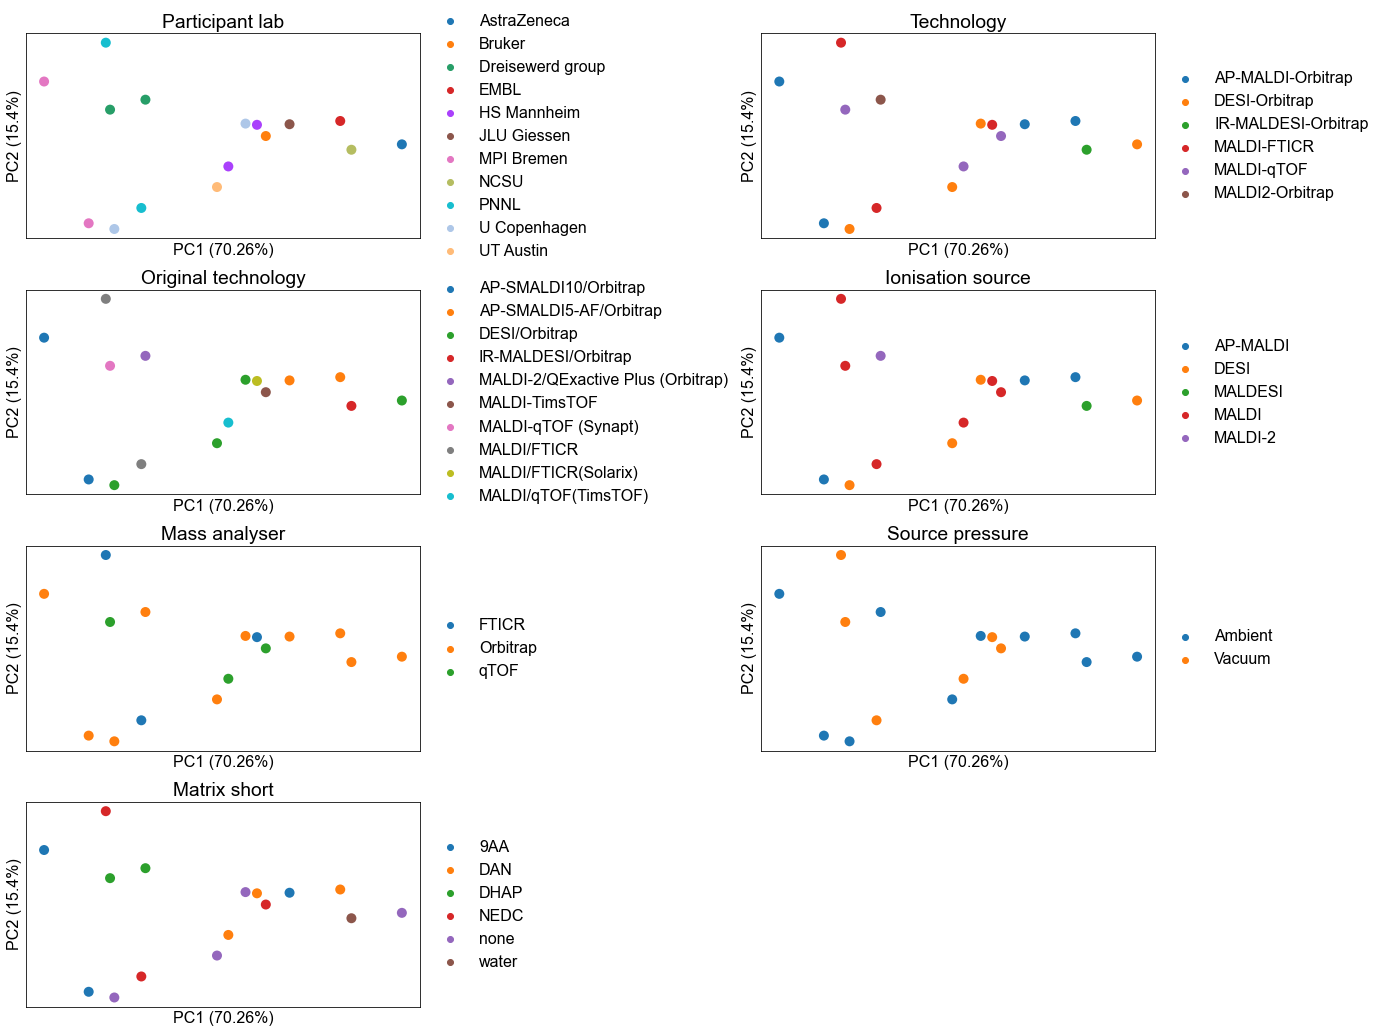

In [18]:
fname = "PCA_interlab_coarse_class_neg"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1, 2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
#                     'Polarity', 
                   ],
                   size=400, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.7,
                   annotate_var_explained = True)
    plt.tight_layout()
    plt.savefig(p_out/ f"{fname}.png")
    plt.savefig(p_out / f"{fname}.pdf")

In [ ]:
# # Extras

# # See how much PCA components explain variance
# sc.pl.pca_variance_ratio(adata)

# # Check loading plot
# sc.pl.pca_loadings(adata, components='1,2')

## Option 3: PCA based on the aggregated values also used in fine class dot plot
- All three opotions provide similar result, but this can be useful for the loading plot

In [24]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='negative', 
                            neutral_losses=['']
                           )

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data, groupby_columns=np.append(metadata_columns, 'name_short').tolist())

# Map chemical classes
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class
class_data = summarise_per_class(mapped_data, groupby_columns=np.append(metadata_columns, 'fine_class').tolist())

# Reshape
pca = class_data.pivot_table(values='fraction_detected', 
                             index=metadata_columns, 
                             columns='fine_class',
                             fill_value=0)

# Assemble adata
adata = assemble_adata(pca)

# # Apply Z-score normalisation
# sc.pp.scale(adata, zero_center=True)

# Compute PCA
sc.tl.pca(adata, svd_solver='arpack')

C:\Users\saharuka\.conda\envs\zimmerman\lib\site-packages\anndata\_core\anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<ipython-input-25-80416f85da68>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


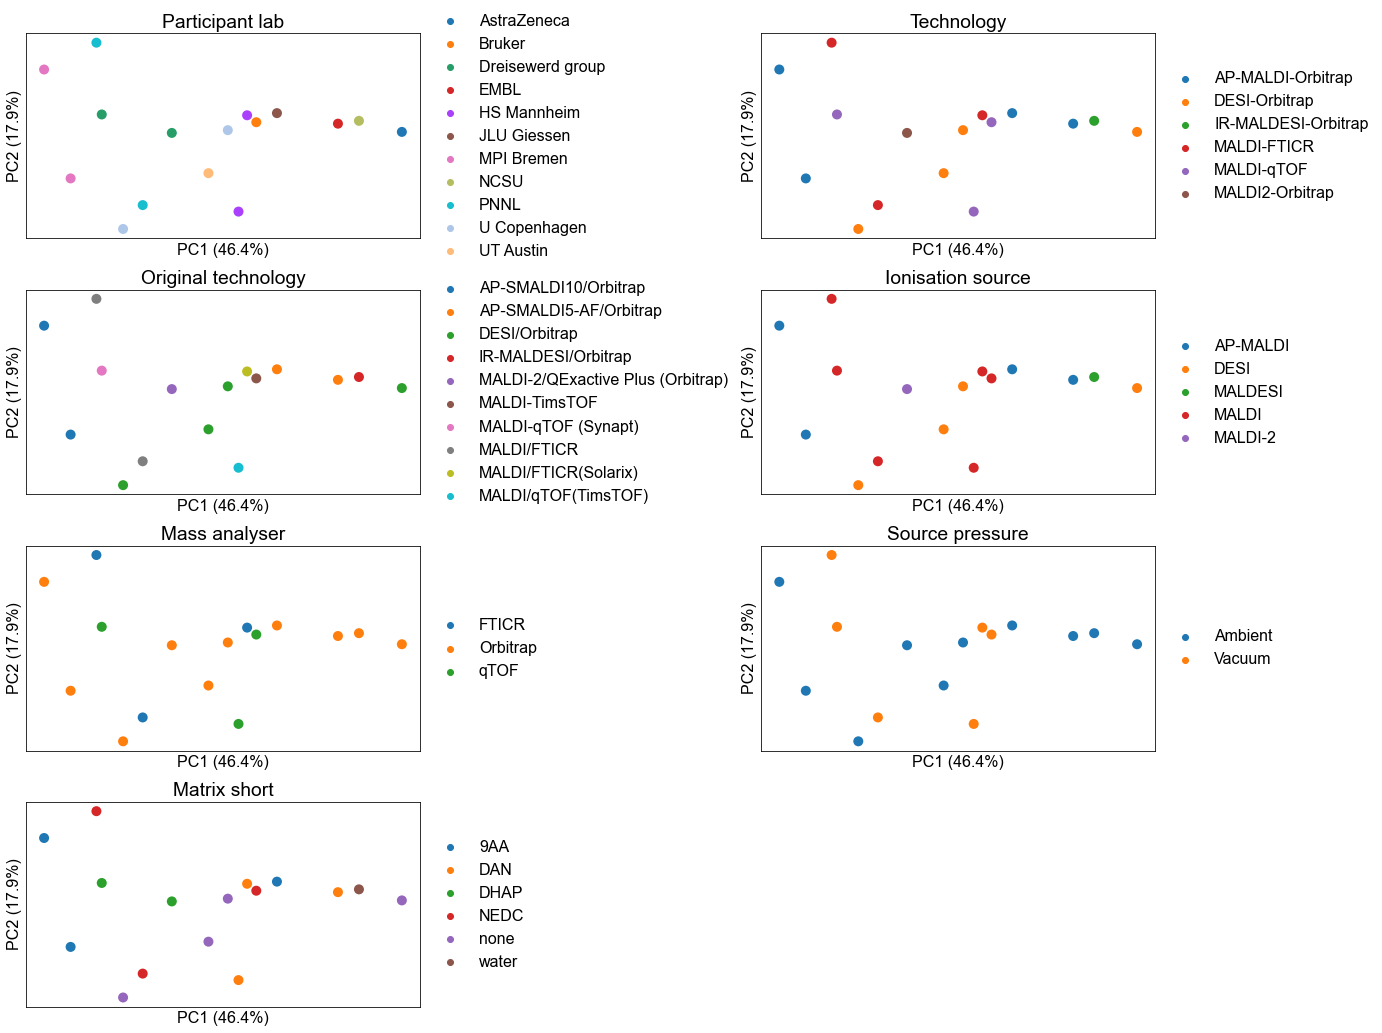

In [25]:
fname = "PCA_interlab_fine_class_neg"

with rc_context():    
    ax = sc.pl.pca(adata, 
                   components=['1,2'], 
                   color=[
#                     'Dataset name', 
                    'Participant lab', 
                    'Technology', 
                    'Original technology', 
                    'Ionisation source',
                    'Mass analyser', 
                    'Source pressure',
                    'Matrix short',
#                     'Polarity', 
                   ],
                   size=400, 
                   ncols=2,
                   legend_loc='right margin',
                   show=False, 
                   wspace=0.7,
                   annotate_var_explained = True)
    plt.tight_layout()
    plt.savefig(p_out/ f"{fname}.png")
    plt.savefig(p_out / f"{fname}.pdf")